In [2]:
# Activate environment in current folder
using Pkg
Pkg.activate(pwd())

  Activating project at `~/Desktop/School Stuff/Winter 2024/Research/2024-frequency-memory`


In [3]:
# Import packages
using Dates, Plots, DifferentialEquations, LaTeXStrings, Statistics, Measures, Peaks, DelimitedFiles, Roots, QuadGK, SpecialFunctions, Interpolations

In [208]:
function integrate(f, p, u0, times; cb = nothing, transient = 0, int_method = Vern9(), dt = false)
    # Helper function to integrate a system of ode
    
    prob = ODEProblem(f, u0, (times[1], times[end]+transient), p, callback = cb)
    sol = solve(prob, int_method, dt = dt, saveat = times .+ transient)

    return sol
end

function palette_from_hex(hex_list)
    # Function that returns a Julia color palette based on a list of hex codes
    hash_list = [string("#", i) for i in hex_list]
    
    pal = []
    for i in hash_list
        push!(pal, parse(Colorant, i))
    end
    return palette(pal)
end

custom_palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])

default(
    linewidth = 4, 
    markerstrokewidth = 0,
    palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])
)

# Plotting formatter
cos_func(x, y) = (x, cos(y))
plt_mod = [(cos_func, 0, 1), (cos_func, 0, 2), 3];


# coupling function
function coupling_atan(x)
    return atan(8*(1-x))/8 + x
end

# defining some functions to detect the phase differences
function center_phase(x; circ = 2*π)
    mod(x + circ/2, circ) - circ/2
end

function circ_distance(x1, x2; circ = 2*π)
    foo1 =  - center_phase.(x1) + center_phase.(x2)
    foo1 = mod.(foo1 .+ π, 2*π) .- π
end

function cluster_detect(points; max_clusters = 4, thresh = 0.05)
    # Function that takes in a list of complex numbers and figures out how many tight clusters there are

    # iterates over possible cycle lengths and checks if each cycle lengths is of order i
    for i in 1:max_clusters
        sections = points[1:i:end] # list of points with the given cycle as interval

        # check if distance of points from their mean is within treshhold
        mm = mean(sections) # average positions of points
        farthest = maximum(abs.(sections .- mm))    # highest distance between points and their average (a perfect cluster would have this as 0)
        if farthest < thresh
            return i    # if we detect that all the points are close enough to the mean, then we conclude that the system is in this cyclic regime
        end
    end

    return NaN # if we go through all the cycles and none present a cyclic behaviour, then we conclude that they are not entrained
end

cluster_detect (generic function with 1 method)

In [8]:
# Pulsatile Core
function f_pulse_core(du, u, p, t)
    du[1] = 2*π*coupling_atan(u[3]) + p[2]*sin(u[2] - u[1])
    du[2] = 2*π*p[1]
    du[3] = -u[3]*p[3]
end

f_pulse_core (generic function with 1 method)

In [214]:
function get_phases(p, u0; thresh = 0.05, plot_traj = true)
    # function that returns a boolean if the simulations are entrained in a 1:1 state

    # Pulse Callback
    condition(u,t,integrator) = sin((u[1])/2)
    affect!(integrator) = integrator.u[3] += p[3]
    cb = ContinuousCallback(condition, affect!, save_positions=(false,false))


    # Times 
    final_time = 50/p[1]
    times = 0:0.005:final_time

    # Integration
    sol = integrate(f_pulse_core, p, u0, times, transient = 1000, cb = cb, int_method = Euler(), dt = 0.003)


    # Get the peaks
    phi_peaks = argmaxima(cos.(sol[1, :]))      # index of the peaks for phi
    theta_peaks = argmaxima(cos.(sol[2, :]))    # index of the peaks for thea 

    # Get the position around unit circle
    phi_phases = exp.(-sol[1, theta_peaks]*1im)
    #cycle_phi = cluster_detect(phi_phases)
    #phi_dist = abs.(phi_phases .- mean(phi_phases))
    #phi_max_dist = maximum(phi_dist)

    theta_phases = exp.(sol[2, phi_peaks]*1im)
    #cycle_theta = cluster_detect(theta_phases)
    #theta_dist = abs.(theta_phases .- mean(theta_phases))
    #theta_max_dist = maximum(theta_dist)


    
    if plot_traj == true 
        # Plot the trajectories
        plt1 = plot(sol, idxs = [(cos_func, 0, 1), (cos_func, 0, 2), 3], title = string("amp: ", p[2], " per: ", 1/p[1]))

        # Plot the unit circle 
        plt2 = plot(exp.((0:2*π*0.01:2*π)*1im), color = :grey, linewidth = 1, label = nothing)
        scatter!(plt2, phi_phases, alpha = 0.5, color = :brown2, label =  L"\phi")
        scatter!(plt2, theta_phases, alpha = 0.5, color = :skyblue, label =  L"\theta")
        
        # Plot the unit circle 
        plt3 = plot(exp.((0:2*π*0.01:2*π)*1im), color = :grey, linewidth = 1, title = L"\theta")
        scatter!(plt3, theta_phases, alpha = 0.5, color = :skyblue)


        l = @layout [a ; a]

        plot(plt1, plt2,  layout = l, aspect_ratio = 1.0)

        savefig(string("test_figs/", "test", ".png"))
        savefig(string("test_figs/", now(), ".png"))
    end

    return phi_phases, theta_phases

    if (cycle_phi == ratio_i) && (cycle_theta == ratio_j)
        return true
    else
        return false
    end
end

function is_entrained(phi_phases, theta_phases, cycle_i, cycle_j)
    if (cycle_i == cluster_detect(phi_phases)) && (cycle_j == cluster_detect(theta_phases))
        return true
    else
        return false
    end
end




for i in 1:5
    phi, theta = get_phases([1/0.6, 1.6, 1], [rand()*2*π, 0, 2.2])
    println(is_entrained(phi, theta, 1, 1))
end

true
true
true
true
true


In [253]:
# now we can make the tongues 
max_i_ratio = 3
max_j_ratio = 3
pers = LinRange(0.4, 2.2, 40)
amps = LinRange(0, 2, 40)
tongue_11 =  fill(NaN, size(pers)..., size(amps)...)
tongue_12 =  fill(NaN, size(pers)..., size(amps)...)
tongue_21 =  fill(NaN, size(pers)..., size(amps)...)
tongue_23 =  fill(NaN, size(pers)..., size(amps)...)
tongue_32 =  fill(NaN, size(pers)..., size(amps)...)

# Note: in principle, we could make an array for all possibles entrainment ratios, but it is not the most practical to save...
tongues = fill(NaN, size(amps)..., size(pers)..., max_i_ratio, max_j_ratio)
        

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)

In [ ]:
for (i, per) in enumerate(pers)
    for (j, amp) in enumerate(amps)
        for k in 1:10
            phi, theta = get_phases([1/per, amp, 0.5], [rand()*2*π, 0, 0.4 + rand()*3])

            for i_cycle in 1:max_i_ratio
                for j_cycle in 1:max_j_ratio
                    if is_entrained(phi, theta, i_cycle, j_cycle)
                        println((i_cycle, j_cycle))
                        #println((per, amp))
                        #println((i, j))
                        tongues[j, i, i_cycle, j_cycle] = 1
                    end
                end
            end          
        end
    end
end

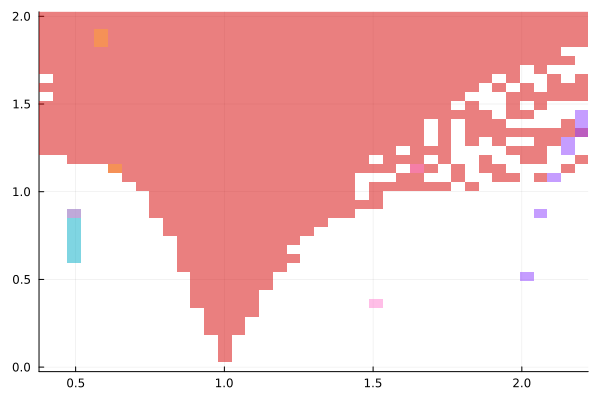

In [262]:
plt = plot(legend = false)
c_id = 1    # index for color
pal = palette(:glasbey_bw_minc_20_n256)

for i in 1:max_i_ratio
    for j in 1:max_j_ratio  
        writedlm(string("tongue_", i, j, ".csv"), tongues[:, :, i, j])
        
        heatmap!(plt, pers, amps, tongues[:, :, i, j], color = pal[c_id], alpha = 0.5)
        c_id += 1
    end
end    


plt

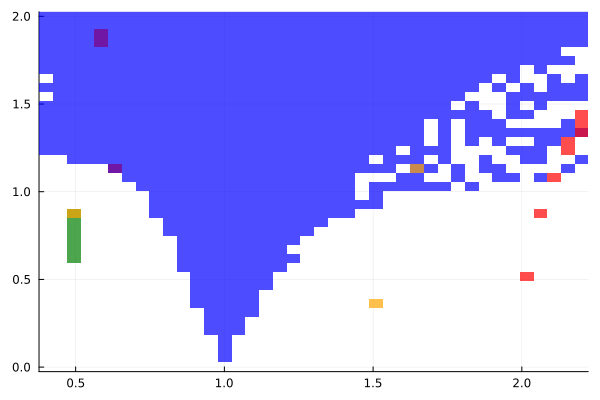

In [261]:
plt = plot(legend = false)
heatmap!(plt, pers, amps, tongues[:, :, 1, 1], color = :blue, alpha = 0.7)
heatmap!(plt, pers, amps, tongues[:, :, 1, 2], color = :red, alpha = 0.7)
heatmap!(plt, pers, amps, tongues[:, :, 2, 1], color = :green, alpha = 0.7)
heatmap!(plt, pers, amps, tongues[:, :, 2, 3], color = :orange, alpha = 0.7)
heatmap!(plt, pers, amps, tongues[:, :, 3, 2], color = :purple, alpha = 0.7)

In [207]:
#writedlm("tongue.csv", tongue_11)

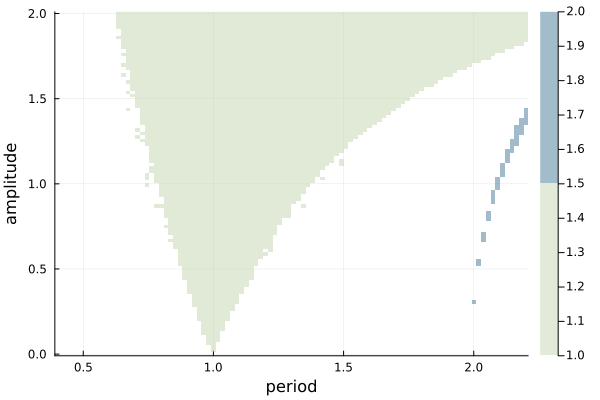

In [206]:
heatmap(pers, amps, tongue_11, color = palette_from_hex(["C4D6B0","477998"]), xlabel = "period", ylabel = "amplitude", alpha = 0.5)

In [117]:
true && false

false

In [138]:
a = [1, 2, 3, 4, 5, 6]
a[1:2:end]

3-element Vector{Int64}:
 1
 3
 5

cluster_detect (generic function with 1 method)

In [49]:
a = rand(1000)
b = rand(1000)

c = a + b*1im
d = exp.(2*π*rand(100)*1im)
std(c)

0.41064959605229

In [52]:
abs.(d)

100-element Vector{Float64}:
 0.9999999999999999
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

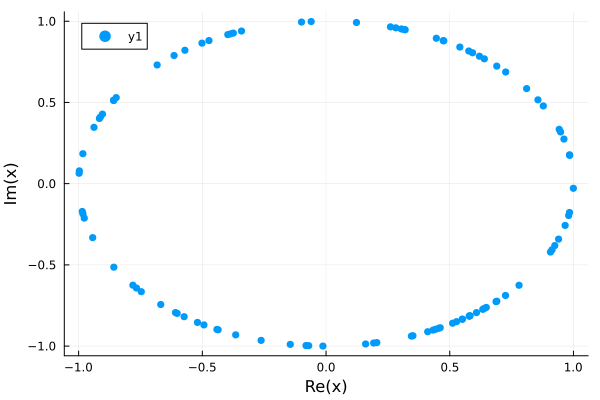

In [50]:
scatter(d)

In [16]:
x = 0:0.01:20
y = cos.(x)
id = argmaxima(y)

3-element Vector{Int64}:
  629
 1258
 1886

In [17]:
x[id]

3-element Vector{Float64}:
  6.28
 12.57
 18.85

In [ ]:
function model_dirac_pulse(c1, c2, omega, k, alpha; thresh = 0.1)
    # function that detects if the system is entrained and then output the phase of entrainement

    function f(du, u, p, t)
        du[1] = 2*π*coupling_atan(u[3], c1, c2) + p[2]*sin(u[2]-u[1])       # phi
        du[2] = 2*π*p[1]                                            # theta
        du[3] = p[3]*( - u[3])    # x
    end

    # Parameter
    p = [
        omega, 
        k,
        alpha,
    ]
    

    

    # Pulse Callback
    condition(u,t,integrator) = sin((u[1])/2)
    affect!(integrator) = integrator.u[3] += p[3]
    cb = ContinuousCallback(condition, affect!, save_positions=(false,false))



    # Initial conditions
    u0 = [
        rand()*2*π,
        0,
        1.2
    ]

    # Times 
    final_time = 20/p[1]
    times = 0:0.001:final_time

    # Integration
    sol = integrate(f, p, u0, times, transient = 0, cb = cb, int_method = Euler(), dt = 0.0001)

    plt1_1 = plot()
    plt1 = plot(sol, idxs = [(cos_func, 0, 1), (cos_func, 0, 2), 3])

    
    

    # now look at poincarre section
    times = 0:1/p[1]:final_time
    sol = integrate(f, p, u0, times, transient = 0, cb = cb, int_method = Euler(), dt = 0.0001)
    scatter!(sol, idxs = [(cos_func, 0, 1), (cos_func, 0, 2), 3])
    dist = circ_distance(sol[1, :], sol[2, :])
    plt2 = scatter(sol.t, dist, label = "Phase difference")

    plot(plt1, plt1_1, plt2, layout = (3,1))

    savefig(string("test_figs/", "test", ".png"))
    #savefig(string("test_figs/", now(), ".png"))



end

model_dirac_pulse(
    8., 
    53., 
    1.2,
    1.35,
    0.1
)